In [60]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn
import collections
import sklearn.decomposition
import sklearn.metrics
import sklearn.preprocessing
import sklearn.cluster

<h2> Load Interaction Matrix and Movie Metadata </h2>

In [2]:
intmatrix = np.load("./data/movie-matrix.npz")["data"]
genre = pd.read_csv("./data/MovieLens/u.item", sep='\t', encoding='latin-1', header=None)

In [3]:
genre = np.array([np.array(s) for s in genre[0].apply(lambda s: np.array(s.split("|"))).values])
genre = genre[:,6:].astype(np.int)
genre_names = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary",
               "Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi",
               "Thriller","War","Western"]
pd.Series(np.sum(genre, axis=1)).value_counts().sort_index(), genre.shape

(0      2
 1    831
 2    569
 3    215
 4     51
 5     11
 6      3
 dtype: int64, (1682, 18))

<h2>User Clusters in Genre Hyperspace </h2>

We use a change-of-base to represent the totality of each user's ratings in a hyperspace of 18 genres. Unsupervised clustering and Principal Component Analysis can be used to extract characteristics of key clusters. Correlation between preferences across genres is evaluated. A $943 \times 1682$ interaction matrix multiplied by a $1682 \times 18$ genre matrix gives the intended $943 \times 18$ per-user representation amongst genres.

In [4]:
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
zmask = intmatrix==0
intmatrix = intmatrix-mean.reshape(-1,1)
intmatrix[zmask]=0
nb = np.matmul(intmatrix, genre)
nb.shape

(943, 18)

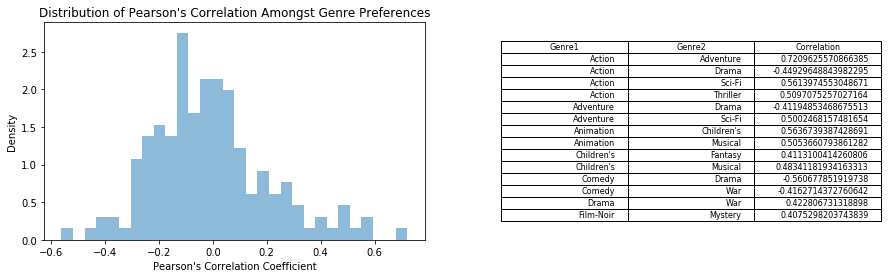

In [5]:
#Bivariate Correlations Over Genres
corrvals = pd.DataFrame(pd.DataFrame(nb).corr().unstack()).reset_index()
corrvals = corrvals[corrvals.level_0<corrvals.level_1].reset_index(drop=True)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(corrvals[0], bins=30, alpha=0.5, density=True)
plt.title("Distribution of Pearson's Correlation Amongst Genre Preferences")
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel("Density")
ax = plt.subplot(1,2,2)
ax.axis('tight')
ax.axis('off')
imp = corrvals[corrvals[0].apply(np.abs)>0.4].copy()
imp[["level_0","level_1"]] = imp[["level_0","level_1"]].applymap(lambda s: genre_names[s])
plt.table(cellText=imp.values, colLabels=["Genre1","Genre2","Correlation"],loc="center")
plt.show()

In [6]:
#Approach 1: Nearest Neighbours in New HyperSpace
def optimized_row_cosine_sim(matrix): #nxm matrix
    dot = np.matmul(matrix, matrix.T) #nxn dot products
    lth = np.sqrt((matrix**2).sum(axis=1)) #nx1 length vector
    rowlth = np.repeat(lth.reshape(-1,1), matrix.shape[0], axis=1)
    collth = np.repeat(lth.reshape(1,-1), matrix.shape[0], axis=0)
    return dot/(rowlth*collth+1e-8) #1e-8 avoids div0 errors for unknown entries
def user_genre_neighbour(genrematrix, intmatrix, user, k):
    sim = optimized_row_cosine_sim(genrematrix)
    matches = np.argsort(sim[user])[-k-1:-1] #To avoid itself
    avgscore = np.mean(intmatrix[matches], axis=0)
    bestindices = np.argsort(avgscore)[-k:]
    return pd.Series(avgscore[bestindices], index=bestindices+1).sort_values(ascending=False)

In [7]:
user_genre_neighbour(nb, intmatrix, 0, 5)

116    1.132927
269    0.816260
275    0.732927
283    0.732927
258    0.732927
dtype: float64

In [8]:
#Approach 2: K-Movie Addition to Embedding Vector using k-Neighbour
#We use the average rating using k-Neighbour for movies, and then try to find the addition of n movies with their
#genre vector weighted by the average rating that gets the closest possible to user embedding
def find_cosine_sim_index(embedmatrix, vector, ignoreset=set()):
    sim = np.matmul(embedmatrix, vector)/((embedmatrix**2).sum(axis=1)+1e-8)
    pos = np.argsort(sim)
    return pos[np.vectorize(lambda s: s not in ignoreset)(pos)][0]
def k_movie_adder(genrematrix, intmatrix, genre, user, n, k):
    sim = optimized_row_cosine_sim(genrematrix)
    matches = np.argsort(sim[user])[-k-1:-1] #To avoid itself
    avgscore = np.mean(intmatrix[matches], axis=0)
    newembed = np.repeat(avgscore.reshape(-1,1)+1, genre.shape[1], axis=1)*genre #+1 to consider unrated content
    vector = genrematrix[user]
    recommends = collections.deque()
    ignoreset = set()
    #Always unit-normalize
    vector = vector/np.sqrt((vector**2).sum())
    while (len(recommends)<5):
        index = find_cosine_sim_index(newembed, vector, ignoreset)
        vector -= newembed[index]
        vector = vector/np.sqrt((vector**2).sum())
        recommends.append(index+1)
        ignoreset.add(index)
    return recommends

In [9]:
k_movie_adder(nb, intmatrix, genre, 0, 5, 5)

deque([539, 1, 892, 1164, 304])

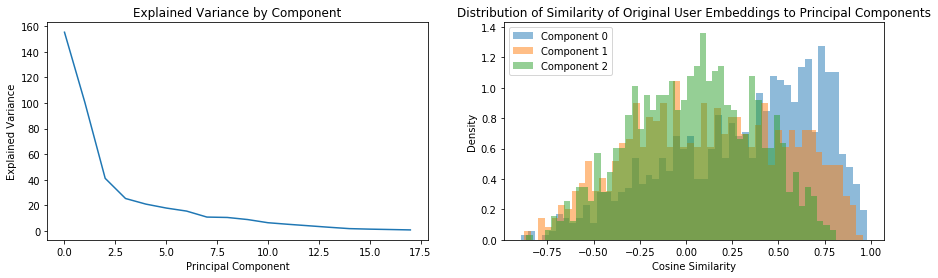

In [32]:
#Approach 3: Principal Component Analysis
pca = sklearn.decomposition.PCA(n_components=None, svd_solver="full", copy=True)
dim = pca.fit_transform(nb)
def principal_axes_similarity(pca, index, nb):
    num = np.matmul(nb, pca.components_[index])
    den = np.sqrt((nb**2).sum(axis=1))*np.sqrt((pca.components_[index]**2).sum())+1e-8
    return num/den
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
pd.Series(pca.explained_variance_).plot()
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by Component")
plt.subplot(1,2,2)
for i in [0,1,2]:
    plt.hist(principal_axes_similarity(pca, i, nb), alpha=0.5, label="Component "+str(i), density=True, bins=50)
plt.legend(loc="best")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Distribution of Similarity of Original User Embeddings to Principal Components")
plt.show()

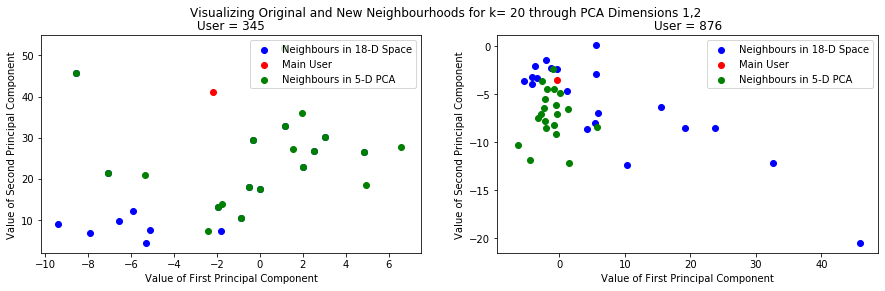

In [50]:
#By the curse of dimensionality, nearest neighbours becomes a less accurate phenomenon due 
#to increasing Eucledian distance to the neighbour (Friedman, Tibshirani, & Hastie, 2001)
#Visualize neighbourhood of two randomly chosen users in original hyperspace, and new 5-component PCA
np.random.seed(0)
k = 20
users = np.random.choice(intmatrix.shape[0], 2, replace=False)
plt.figure(figsize=(15,4))
for index in [0,1]:
    plt.subplot(1,2,index+1)
    sim1 = optimized_row_cosine_sim(nb)
    sim2 = optimized_row_cosine_sim(dim[:,:5])
    match1 = np.argsort(sim1[users[index]])[-k-1:]
    match2 = np.argsort(sim2[users[index]])[-k-1:]
    plt.scatter(dim[match1[:-1],0], dim[match1[:-1],1], color="blue", label="Neighbours in 18-D Space")
    plt.scatter(dim[match1[-1],0], dim[match1[-1],1], color="red", label="Main User")
    plt.scatter(dim[match2[:-1],0], dim[match2[:-1],1], color="green", label="Neighbours in 5-D PCA")
    plt.xlabel("Value of First Principal Component")
    plt.ylabel("Value of Second Principal Component")
    plt.title("User = "+str(users[index]))
    plt.legend(loc="upper right")
plt.suptitle("Visualizing Original and New Neighbourhoods for k= "+str(k)+" through PCA Dimensions 1,2")
plt.show()

<h2>Cold-Start Problem</h2>

Our approach to the cold-start problem is to use the above user models after a sufficient n ratings are collected, $n \in \mathbb{N}$. We begin for new users by clustering PCA genre data using unsupervised clustering algorithms, and suggesting one movie from each cluster to understand user preferences.

In [57]:
#Number of components chosen empirically from explained variances
pca = sklearn.decomposition.PCA(n_components=10, svd_solver="full", copy=True)
mv = pca.fit_transform(genre)

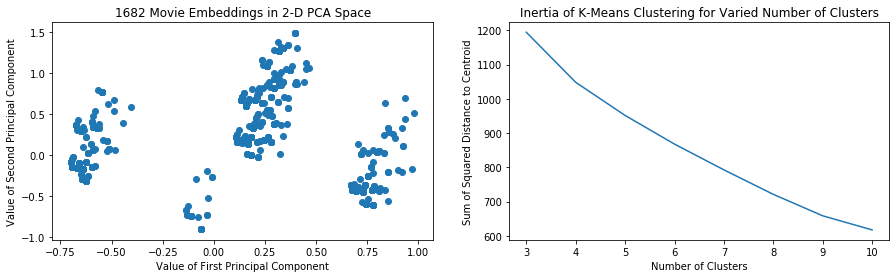

In [77]:
clusters, values = np.arange(3,11,1), np.arange(3,11,1, dtype=np.float64)
for n in clusters:
    cls = sklearn.cluster.KMeans(n_clusters=n, init="k-means++", n_init=30, max_iter=1000, 
                                 tol=1e-10, random_state=1)
    cls.fit(mv)
    values[n-3] = cls.inertia_ 
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.scatter(mv[:,0], mv[:,1])
plt.xlabel("Value of First Principal Component")
plt.ylabel("Value of Second Principal Component")
plt.title("1682 Movie Embeddings in 2-D PCA Space")
plt.subplot(1,2,2)
plt.plot(clusters, values)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distance to Centroid")
plt.title("Inertia of K-Means Clustering for Varied Number of Clusters")
plt.show()

<h2>User-Demographic Probability Smoothening </h2>